# Advanced Computational Methods in Statistics
### Gerardo Durán-Martín

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dataclasses import dataclass
from functools import partial

In [2]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

jnp.set_printoptions(precision=5, suppress=True)

$$
\begin{aligned}
    X_n &= \rho X_{n-1} + \tau V_n\\
    Y_n &= X_n + \sigma W_n
\end{aligned}
$$
with

* $V_n, W_n \sim \mathcal{N}(0, 1)$
* $X_0 \sim \mathcal{N}(0, 1)$

In [3]:
@dataclass
class SSM:
    rho: float
    tau: float
    sigma: float

In [4]:
ssm = SSM(rho=0.8, tau=1, sigma=0.1)

In [5]:
def sample_step(x_prev, key, ssm):
    latent_noise, obs_noise = jax.random.normal(key, (2,))
    
    x_next = ssm.rho * x_prev + ssm.tau * latent_noise
    y_next = x_next + ssm.sigma * obs_noise
    
    state = {"x": x_next, "y": y_next}
    return x_next, state

In [6]:
num_timesteps  = 500
key = jax.random.PRNGKey(314)
key_init, *key_steps = jax.random.split(key, num_timesteps + 1)
key_steps = jnp.r_[key_steps]

x_init = jax.random.normal(key_init)

sample_step_part = partial(sample_step, ssm=ssm)

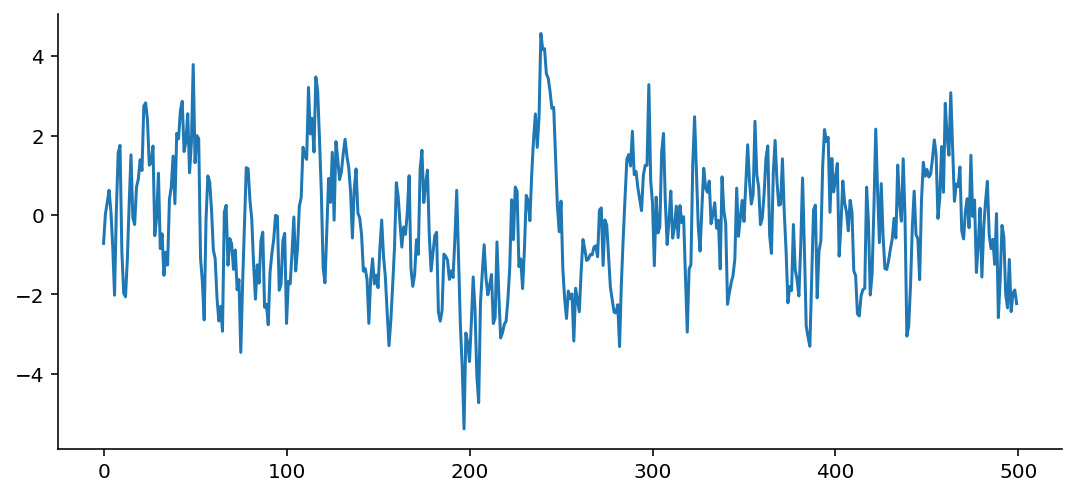

In [7]:

_, hist = jax.lax.scan(sample_step_part, x_init, key_steps)

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(hist["y"])

In [8]:
from jsl.nlds.sequential_monte_carlo import NonMarkovianSequenceModel
from jsl.lds.kalman_filter import LDS, filter

In [9]:
smc = NonMarkovianSequenceModel(ssm.rho, 1, ssm.tau ** 2, ssm.sigma ** 2)

In [10]:
res = smc.sequential_monte_carlo(key, hist["y"], n_particles=100)

In [11]:
res.keys()

dict_keys(['indices', 'log_weights', 'particles', 'weights'])

In [28]:
res["particles"][0]

DeviceArray([-0.9768 , -1.19625, -1.39274, -0.27214,  0.60653,  1.23296,
             -0.42486,  2.49084, -0.19415, -0.48571, -0.6343 ,  0.7447 ,
              2.33345,  0.12325, -1.13463,  1.18769, -2.10518, -1.83402,
              2.53271, -1.29118, -0.35411,  0.72428,  0.39831, -1.3178 ,
             -1.30468,  1.89398, -2.27191,  1.08636,  2.78573,  0.38764,
              0.39662, -0.12432,  1.99582, -2.15225, -0.61519, -1.91375,
              0.94161,  1.81237,  0.80923, -1.14074, -0.37473,  0.23349,
             -0.80228,  0.48357, -2.80643,  0.67342,  2.6684 ,  0.47611,
              1.14583, -0.09622, -1.18753, -0.15632, -3.58373, -1.40934,
             -0.631  , -0.90023, -1.63321, -1.41366,  0.84688, -0.62953,
              0.19721, -1.20044, -0.7652 ,  0.68838,  0.54001, -3.57507,
              0.57146, -0.34563, -2.17841,  0.05842, -0.45474,  0.34234,
             -1.96338, -0.76617, -1.02097, -0.48619, -2.37861, -1.03995,
             -1.64463,  1.31625,  0.46076,  0.00297

In [29]:
res["weights"][0]

DeviceArray([0.01619, 0.01493, 0.01332, 0.01517, 0.00698, 0.0025 ,
             0.01605, 0.0001 , 0.01461, 0.01631, 0.01669, 0.00576,
             0.00016, 0.01177, 0.01535, 0.00273, 0.00639, 0.00897,
             0.00009, 0.0142 , 0.01568, 0.00593, 0.009  , 0.01398,
             0.01409, 0.00055, 0.005  , 0.0033 , 0.00004, 0.0091 ,
             0.00901, 0.01405, 0.00042, 0.00597, 0.01666, 0.00818,
             0.00424, 0.00068, 0.00523, 0.01531, 0.0158 , 0.01067,
             0.01669, 0.00815, 0.00189, 0.00637, 0.00005, 0.00822,
             0.00296, 0.01382, 0.01499, 0.01432, 0.00027, 0.01317,
             0.01669, 0.01647, 0.011  , 0.01313, 0.00493, 0.01668,
             0.01103, 0.0149 , 0.01673, 0.00624, 0.00761, 0.00028,
             0.00731, 0.01563, 0.00575, 0.0124 , 0.01618, 0.00956,
             0.0077 , 0.01673, 0.01599, 0.01631, 0.00421, 0.01589,
             0.01089, 0.00212, 0.00837, 0.01293, 0.00896, 0.01482,
             0.01532, 0.00048, 0.01618, 0.01538, 0.00018, 0.01

In [14]:
expected_value = jnp.einsum("tn,tn->t", res["weights"], res["particles"])
expected_value2 = jnp.einsum("tn,tn->t", res["weights"], res["particles"] ** 2)

In [19]:
posterior_std = jnp.sqrt((expected_value2 - expected_value ** 2))

In [21]:
lds = LDS(jnp.array([[ssm.rho]]), jnp.array([1.0]),
          jnp.array([[ssm.tau]]) ** 2, jnp.array([[ssm.sigma]]) ** 2,
          jnp.array([0.0]), jnp.array([[1.0]]))

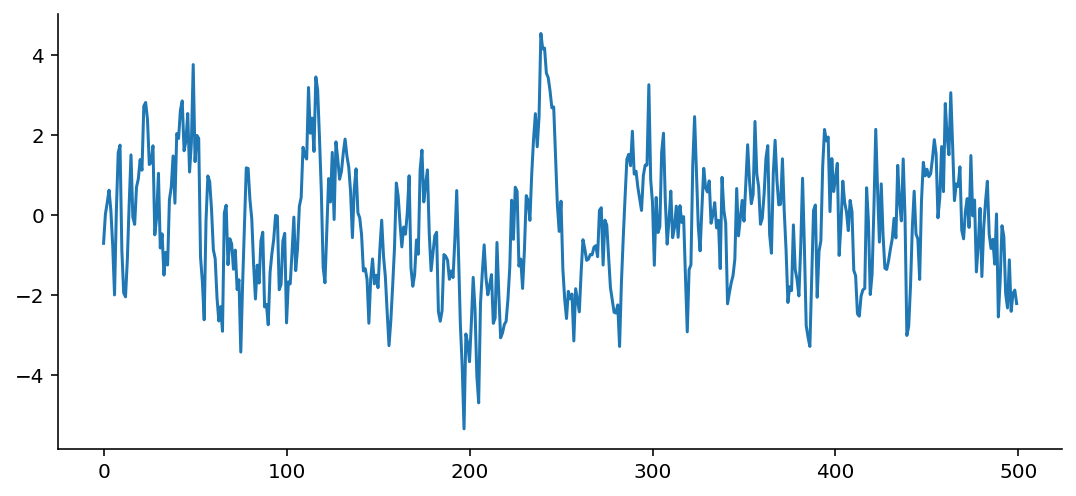

In [25]:
(mu_hist, Sigma_hist, mu_cond_hist, Sigma_cond_hist) = filter(lds, hist["y"][:, None])
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(mu_hist.ravel())

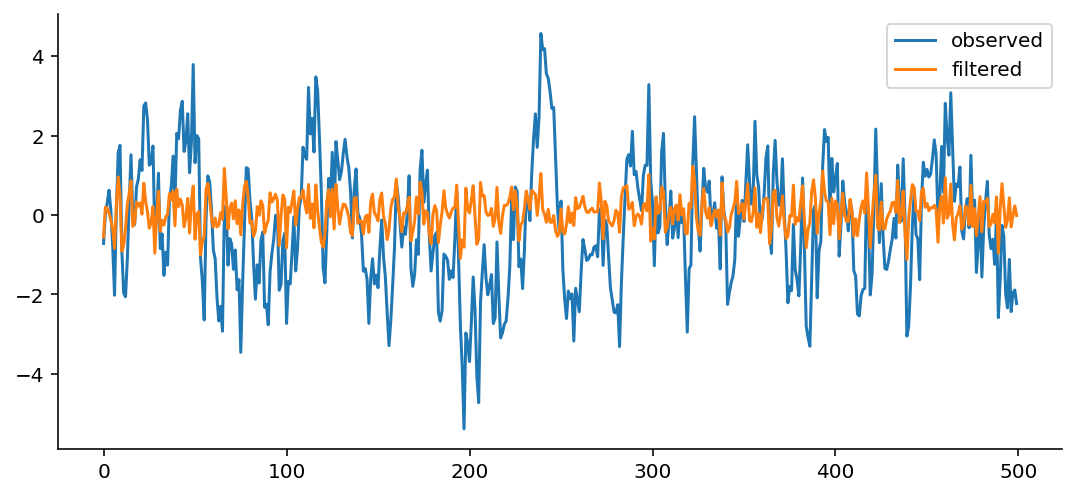

In [23]:
fig, ax = plt.subplots(figsize=(9, 4))
plt.plot(hist["y"], label="observed")
plt.plot(expected_value, label="filtered")
plt.legend()